# Bioconductor analisis

##### Setup olivia

In [1]:
# Olivia Finder requirements
%pip install -r ../olivia/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from time import time
import networkx as nx
import psutil
from collections import Counter

# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')

from olivia.model import OliviaNetwork


Set up variables

In [2]:
REPO_NAME = "Bioconductor"
OUT_IMG_DIR = f"../img/{REPO_NAME}"

# Create output directory
if not os.path.exists(OUT_IMG_DIR):
    os.makedirs(OUT_IMG_DIR)



#### **Utilities**

In [35]:

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        return G
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color, save=False, filename=None):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Set title
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    # Plot linear histogram
    # Order nodes' degree vector
    sorted_degree = sorted(degree, reverse=True)
    axs[0].plot(sorted_degree, color=color)
    axs[0].set_xlabel('Nodes')
    axs[0].set_ylabel('Degree')
    axs[0].set_yscale('log')
    
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    # Save figure
    if save:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph

# def plot_comparation(m1, m2, t_m1, t_m2, offset=0):
#     plt.figure(figsize=(15, 3))
    
#     # Gráfico para libraries.io
#     plt.subplot(1, 2, 1)
#     plt.bar([x[0] for x in m1], [x[1] for x in m1], color='orange')
#     plt.xticks(rotation=90)
#     plt.title(t_m1, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m1)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m1]
#     for i in range(len(m1)):
#         plt.text(i, bar_size[i] + offset , str(bar_size[i]), ha='center', va='center', color='black')

#     # Gráfico para Scraped Packages
#     plt.subplot(1, 2, 2)
#     plt.bar([x[0] for x in m2], [x[1] for x in m2], color='purple')
#     plt.xticks(rotation=90)
#     plt.title(t_m2, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m2)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m2]
#     for i in range(len(m2)):
#         plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='white')

#     plt.show()

def plot_comparison(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


def plot_comparison_reversed(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

def plot_bar_chart(m1, m2, tit, offset = 1000):
    # Configuring colors
    colors = ['orange', 'purple']

    # Heights of the bars
    height_libio = [node[1] for node in m1]
    height_scraped = [node[1] for node in m2]

    # Create the bar plot (one bar next to each other)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(m1)), height_libio, color=colors[0], width=0.4)
    ax.bar(np.arange(len(m2)) + 0.4, height_scraped, color=colors[1], width=0.4)

    # Configure xticks orientation and position
    ax.set_xticks(np.arange(len(m1)) + 0.2)
    ax.set_xticklabels([node[0] for node in m1], rotation=45, ha='right', fontsize=8)

    # Configure titles and axis labels
    ax.set_title(tit, fontsize=20, fontweight='bold')
    ax.set_xlabel('Package')
    ax.set_ylabel('In degree')

    # Add labels to the sections of the bar chart
    for i, v in enumerate(height_libio):
        ax.text(i, v + offset, str(v), ha='center', va='center', color='black', rotation=90)
    for i, v in enumerate(height_scraped):
        ax.text(i + 0.4, v + offset, str(v), ha='center', va='center', color='black', rotation=90)

    # Add a horizontal grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjusting tick labels font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Configure legend
    legend_labels = ['librariesio', 'scraped']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(legend_handles, legend_labels)

    # Show the bar plot
    plt.show()

def calculate_metrics(G):
    '''
    Calculates the following metrics for a given graph:
    - Number of nodes
    - Number of edges
    - Average clustering coefficient
    - Average shortest path length
    - Number of connected components
    - Diameter
    - Average degree
    - Average in degree
    - Average out degree
    - Number of self-loops
    - Number of isolated nodes
    '''
    
    return pd.DataFrame(
        {
            'Number of nodes': [G.number_of_nodes()],
            'Number of edges': [G.number_of_edges()],
            'Average clustering coefficient': [nx.average_clustering(G)],
            'Average degree': [sum(dict(G.degree()).values())/G.number_of_nodes()],
            'Average in degree': [sum(dict(G.in_degree()).values())/G.number_of_nodes()],
            'Average out degree': [sum(dict(G.out_degree()).values())/G.number_of_nodes()],
            'Number of isolated nodes': [len(list(nx.isolates(G)))]
        }
    )

def plot_dict(d, title, xlabel, ylabel, rotation=90, size=None, offset=100, label_size=12, label_rotation=0, font_size=14, color='orange', tit_pad=20, w=0.4, save=False, filename=None):
    '''
    Plots a dictionary as a bar chart.
    '''

    plt.figure(figsize=size)
    plt.bar(d.keys(), d.values(), color=color, width=w)
    # add text size
    plt.xticks(rotation=label_rotation, fontsize=label_size)
    plt.title(title, fontsize=20, fontweight='bold', pad=tit_pad)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=label_size)
    plt.gca().tick_params(axis='y', labelsize=label_size)
    bar_size = [x[1] for x in d.items()]
    for i in range(len(d)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='black', rotation=rotation, size=font_size)

    # Save plot
    if save:
        plt.savefig(filename, bbox_inches='tight')  # Use bbox_inches='tight' to prevent cropping

    plt.show()


def plot_data(data, metric, title, color):
    data.sort(reverse=True)
    plt.figure(figsize=(10, 5))
    x, y = zip(*Counter(data).items())
    plt.plot(x, y, color=color, alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')

    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    # plt.xscale('log')
    plt.yscale('log')
    # grid
    plt.grid(axis='y', alpha=0.5)
    plt.grid(axis='x', alpha=0.5)

    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    plt.legend()
    plt.show()


## 1 - Data processing

### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [4]:
scraped_df = pd.read_csv('../results/csv_datasets/bioconductor/bioconductor_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['version', 'url', 'dependency_version', 'dependency_url'])
print(scraped_df.shape)
scraped_df.head()


(28327, 2)


,name,dependency
0,ABSSeq,R
1,ABSSeq,methods
2,ABSSeq,locfit
3,ABSSeq,limma
4,AMOUNTAIN,R


As can be observed, this dataset contains 197460 distinct packages.

In [9]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

# Number of rows with unique dependency values
print("Unique values at column 'dependency': ", len(scraped_df['dependency'].unique()))

# Set con ambos valores únicos
scraped_names = scraped_df['name'].unique()
scraped_dependencies = scraped_df['dependency'].unique()

# concateno los dos arrays
scraped_names_dependencies = np.concatenate((scraped_names, scraped_dependencies), axis=None)

# unique values
print("Unique values at column 'name' and 'dependency': ", len(np.unique(scraped_names_dependencies)))


Unique values at column 'name':  2213
Unique values at column 'dependency':  1902
Unique values at column 'name' and 'dependency':  3509


## 2 - Comparation

### **Packages evolution**

### **Network analysis**

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [10]:


# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=253678, name='python', status='running', started='18:37:19')
Initializing graph... OK
0.0M lines | 3509 nodes, 28320 deps. (0s) 138.8Mb
Done processing DataFrame


In [20]:
# NUmero de nodos
print("Number of nodes: ", scraped_G.number_of_nodes())

# Numero de edges
print("Number of edges: ", scraped_G.number_of_edges())

# grado medio
print("Average degree: ", sum(dict(scraped_G.degree()).values())/scraped_G.number_of_nodes())

# diametro
# print("Diameter: ", nx.diameter(scraped_G))

# clustering
print("Average clustering coefficient: ", nx.average_clustering(scraped_G))






Number of nodes:  3509
Number of edges:  28320
Average degree:  16.141350812197206
Average clustering coefficient:  0.0776288322095149


In [11]:


# Scraped based model
scraped_model = OliviaNetwork()
scraped_model.build_model(scraped_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


#### **1 - Degree**

Regarding the degree distribution, no significant changes are observed.

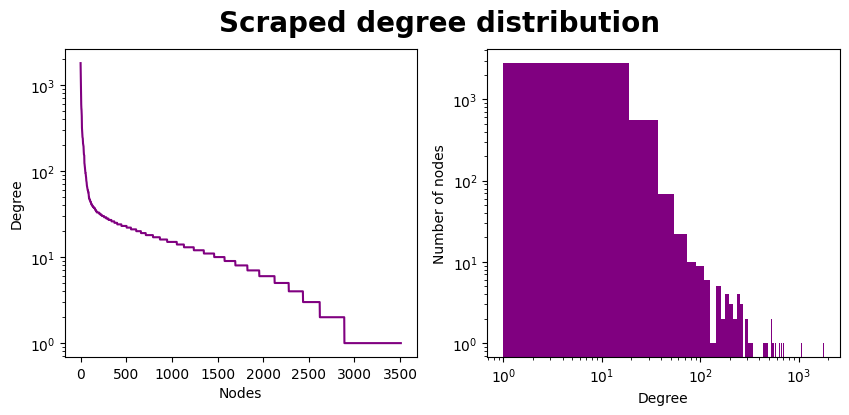

In [12]:
plot_degree_distribution(scraped_G, 'Scraped degree distribution', "purple", save=True, filename=f'{OUT_IMG_DIR}/scraped_degree_distribution.png')

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [ ]:
# Libraries.io graph average degree
print("Average degree of libraries.io graph: ", librariesio_G.number_of_edges() / librariesio_G.number_of_nodes())
# Scraped graph average degree
print("Average degree of scraped graph: ", scraped_G.number_of_edges() / scraped_G.number_of_nodes())



Average degree of libraries.io graph:  2.729383847807569
Average degree of scraped graph:  4.354711614678044


#### **2 - Out degree**

##### Evolution

Top out degree librariesio packages evolution

Top out degree scraped packages evolution

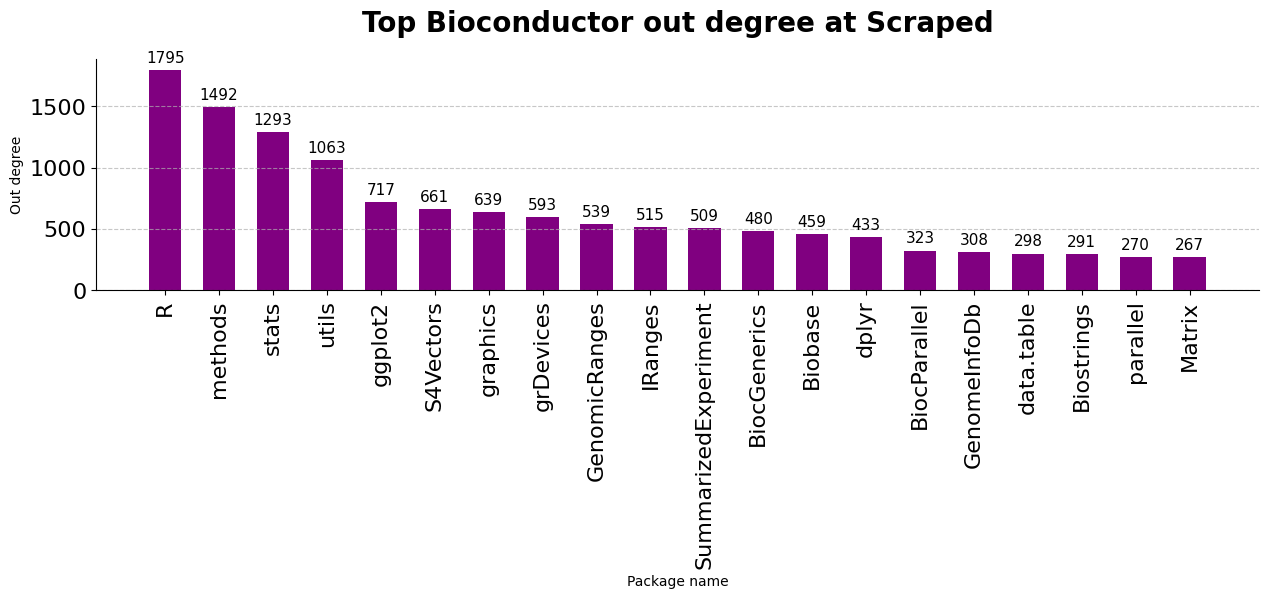

In [22]:
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_outd),
    title = f'Top {REPO_NAME} out degree at Scraped',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    color='purple',
    rotation = 0,
    size = (15, 3),
    offset = 100,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd.png',
)






##### Global out degree distribution

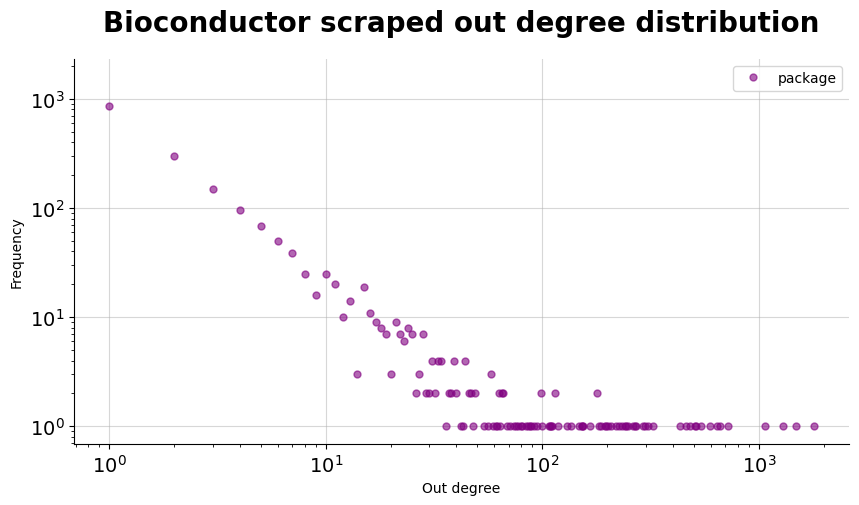

In [26]:


plot_data(
    data = [x[1] for x in scraped_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} scraped out degree distribution',
    color="purple"
)

#### **3 - In degree**

##### Evolution

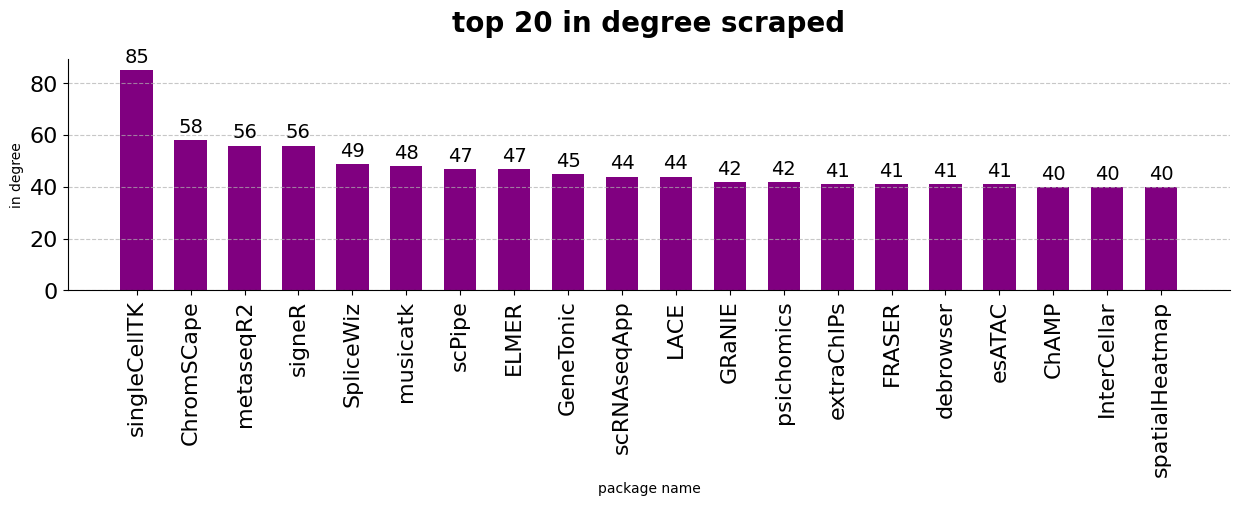

In [30]:
scraped_t20_ind = sorted(scraped_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_ind),
    title = 'top 20 in degree scraped',
    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 5,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    color = 'purple',
    w=0.6
)



##### Global in degree distribution

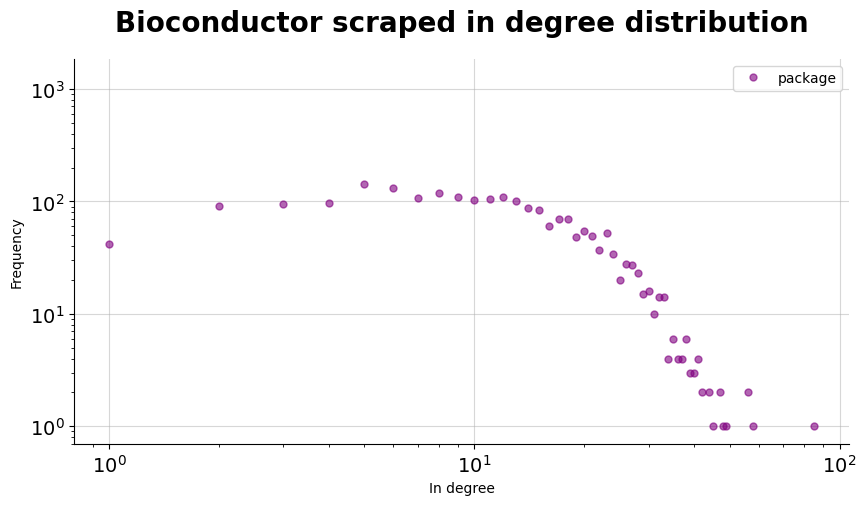

In [31]:
scraped_in_degree = [x[1] for x in scraped_G.in_degree()]
plot_data(scraped_in_degree, 'In degree', f'{REPO_NAME} scraped in degree distribution', 'purple')

#### **4 - Pagerrank**

##### Evolution

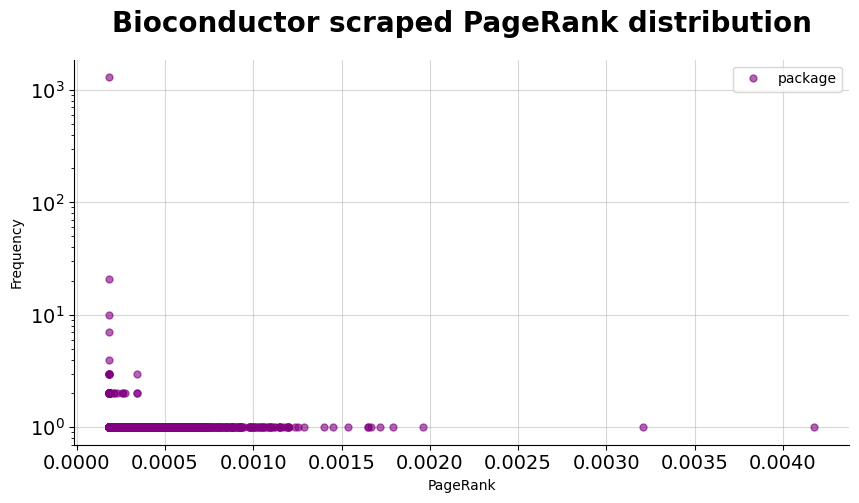

In [36]:
# Pagerank distribution
# ---------------------

# Libraries.io
scraped_pagerank = list(dict(nx.pagerank(scraped_G)).values())
plot_data(scraped_pagerank, 'PageRank', f'{REPO_NAME} scraped PageRank distribution', 'purple')

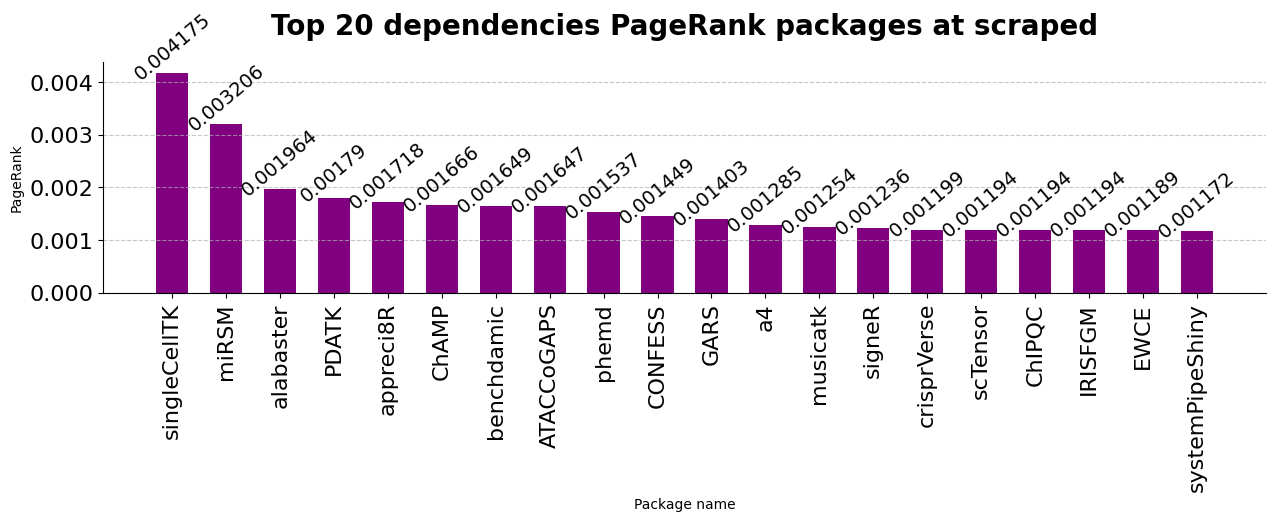

In [40]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 6)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 dependencies PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.0005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)




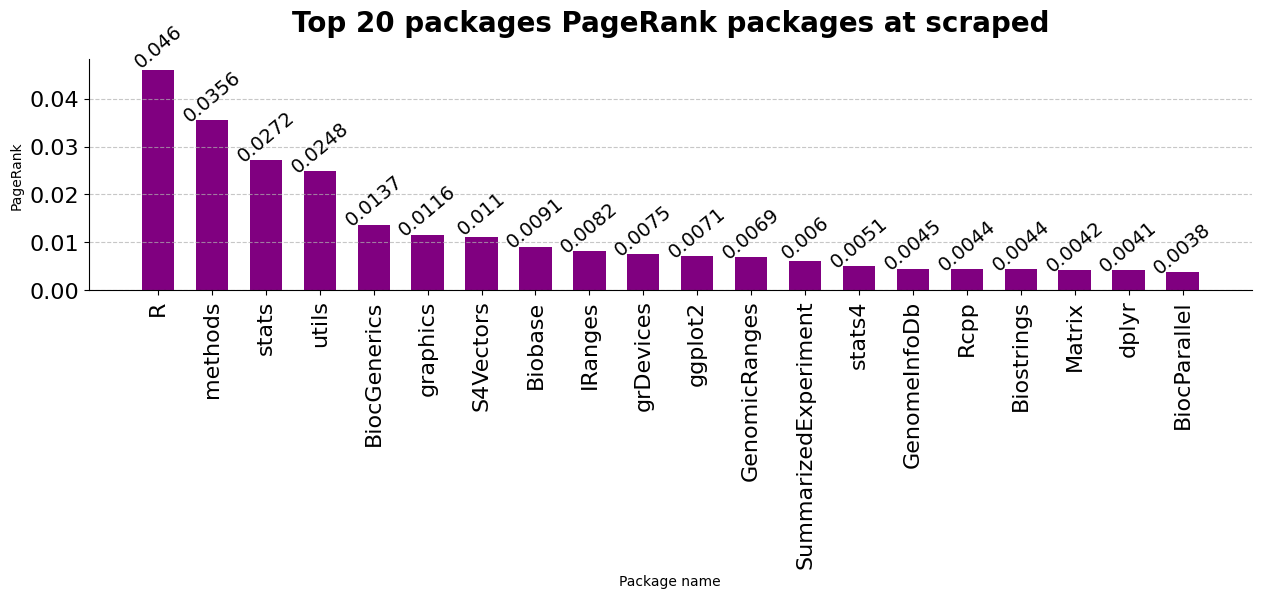

In [42]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G.reverse()).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 packages PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)




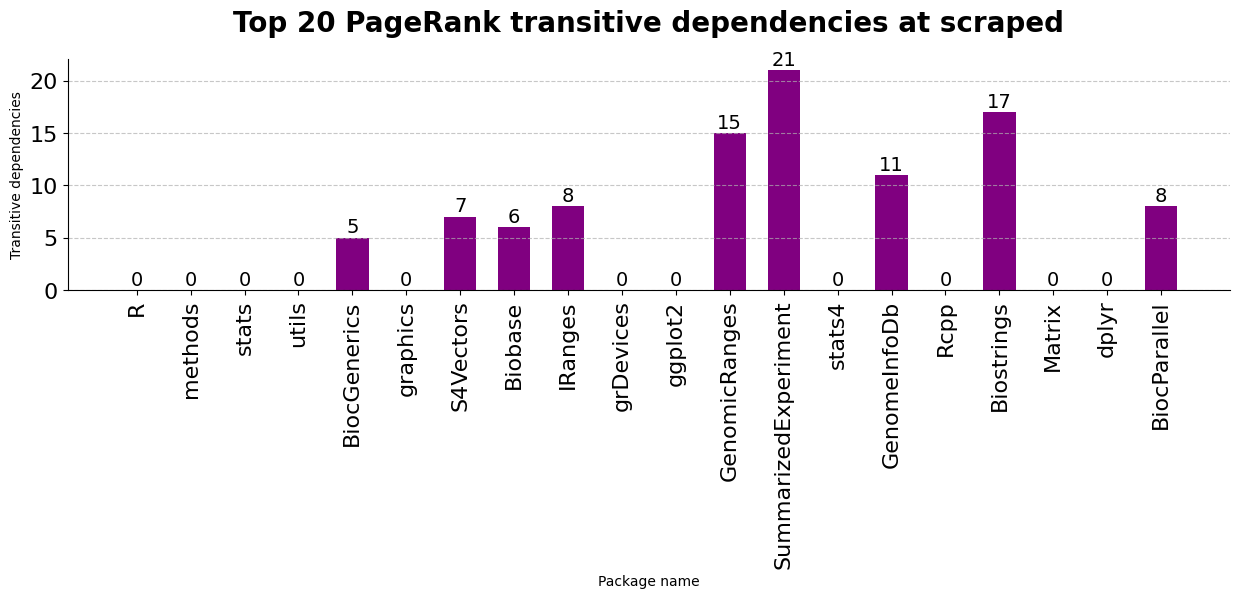

In [44]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in scraped_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(scraped_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at scraped',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    color='purple',
    rotation = 0,
    offset=1,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)
    

We can compare other interesting metrics as well.

### **Olivia metrics**

#### **1 - Atack vulnerability**

In [ ]:
from olivia.networkmetrics import attack_vulnerability

librariesio_model_attack_vulnerability = attack_vulnerability(librariesio_model, normalize=True)
scraped_model_attack_vulnerability = attack_vulnerability(scraped_model, normalize=True)

print('Attack vulnerability librariesio: {}'.format(librariesio_model_attack_vulnerability))
print('Attack vulnerability scraped: {}'.format(scraped_model_attack_vulnerability))
print('Increase in attack vulnerability: {}'.format(scraped_model_attack_vulnerability - librariesio_model_attack_vulnerability))

Computing Reach


     Processing node: 49K      
Computing Reach
     Processing node: 213K      
Attack vulnerability librariesio: 0.38964831866304306
Attack vulnerability scraped: 0.6760852333659719
Increase in attack vulnerability: 0.28643691470292887


#### **2 - Failure vulnerability**

In [ ]:
from olivia.networkmetrics import failure_vulnerability

librariesio_model_failure_vulnerability = failure_vulnerability(librariesio_model, normalize=True)
scraped_model_failure_vulnerability = failure_vulnerability(scraped_model, normalize=True)

print('Failure vulnerability librariesio: {}'.format(librariesio_model_failure_vulnerability))
print('Failure vulnerability scraped: {}'.format(scraped_model_failure_vulnerability))
print('Increase in failure vulnerability: {}'.format(scraped_model_failure_vulnerability - librariesio_model_failure_vulnerability))

Reach retrieved from metrics cache
Reach retrieved from metrics cache
Failure vulnerability librariesio: 0.0001738793933286081
Failure vulnerability scraped: 0.0022826054428677265
Increase in failure vulnerability: 0.0021087260495391185


#### **3 - Reach**

In [ ]:
from olivia.packagemetrics import Reach

librariesio_reach = librariesio_model.get_metric(Reach)
scraped_reach = scraped_model.get_metric(Reach)

Reach retrieved from metrics cache
Reach retrieved from metrics cache


**Top reach**

######

In [ ]:
# Top 10 Reach
# ------------

top10_reach_librariesio = librariesio_reach.top(10)
top10_reach_scraped = scraped_reach.top(10)

# Top 10 Reach comparison
top10_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_reach_librariesio,
        'scraped': top10_reach_scraped
    }
)

top10_reach_comparison

,librariesio,scraped
0,"(six, 19212)","(numpy, 145000)"
1,"(certifi, 14155)","(importlib, 142309)"
2,"(requests, 13655)","(six, 142282)"
3,"(pyparsing, 8681)","(colorama, 142116)"
4,"(packaging, 8308)","(typing, 142045)"
5,"(appdirs, 7874)","(python, 142018)"
6,"(setuptools, 7340)","(click, 141302)"
7,"(python-dateutil, 6592)","(chardet, 140543)"
8,"(numpy, 4937)","(django, 140508)"
9,"(attrs, 4311)","(Cython, 140502)"


**Bottomb reach**

######

In [ ]:
# Top 10 least Reach
# ------------------

top10_least_reach_librariesio = librariesio_reach.bottom(10)
top10_least_reach_scraped = scraped_reach.bottom(10)

# Top 10 least Reach comparison
top10_least_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_least_reach_librariesio,
        'scraped': top10_least_reach_scraped
    }
)

top10_least_reach_comparison

,librariesio,scraped
0,"(pytest-testdox, 1)","(lol-id-tools, 1)"
1,"(pytest-json-report, 1)","(logipass, 1)"
2,"(pytest-random-order, 1)","(loghub, 1)"
3,"(pytest-twisted, 1)","(lodek-bookman, 1)"
4,"(pytest-markers-presence, 1)","(lockdoor, 1)"
5,"(pytest-only, 1)","(llamazure.azgraph, 1)"
6,"(nutsflow, 1)","(livyclient, 1)"
7,"(mydict, 1)","(livingmodels, 1)"
8,"(optimuspyspark, 1)","(littlefieldpy, 1)"
9,"(1pass, 1)","(0x-sra-client, 1)"


**Top reach increase, decrease and variation**

######

In [ ]:
# Dataframe with the differences between the two models
librariesio_reach_df = pd.DataFrame(librariesio_reach.results_dict, index=['librariesio']).T
scraped_reach_df = pd.DataFrame(scraped_reach.results_dict, index=['scraped']).T

reach_df = pd.concat([librariesio_reach_df, scraped_reach_df], axis=1)
reach_df['increment'] = reach_df['scraped'] - reach_df['librariesio']
reach_df.sort_values(by='increment', ascending=False, inplace=True)
reach_df.head(10)

,librariesio,scraped,increment
importlib,24.0,142309.0,142285.0
typing,1414.0,142045.0,140631.0
colorama,1531.0,142116.0,140585.0
Cython,74.0,140502.0,140428.0
genshi,5.0,140394.0,140389.0
BeautifulSoup4,70.0,140393.0,140323.0
cssselect,239.0,140393.0,140154.0
html5lib,254.0,140386.0,140132.0
numpy,4937.0,145000.0,140063.0
webencodings,733.0,140387.0,139654.0


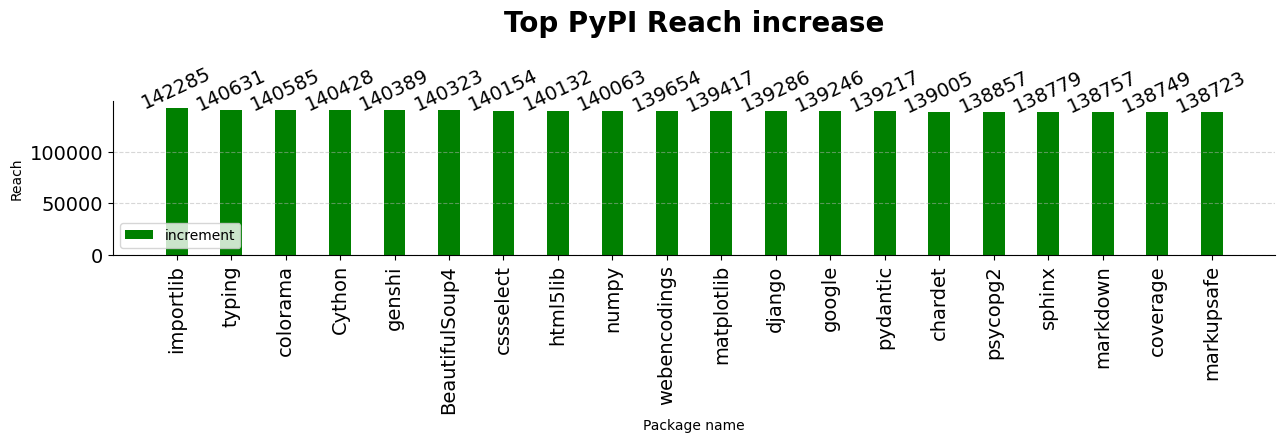

In [ ]:
# Top reach increase
# ------------------

increment = reach_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 2))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Reach increase', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(f'{OUT_IMG_DIR}/top_reach_increase.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_142604/773171109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decrement.sort_values(by='increment', ascending=True, inplace=True)


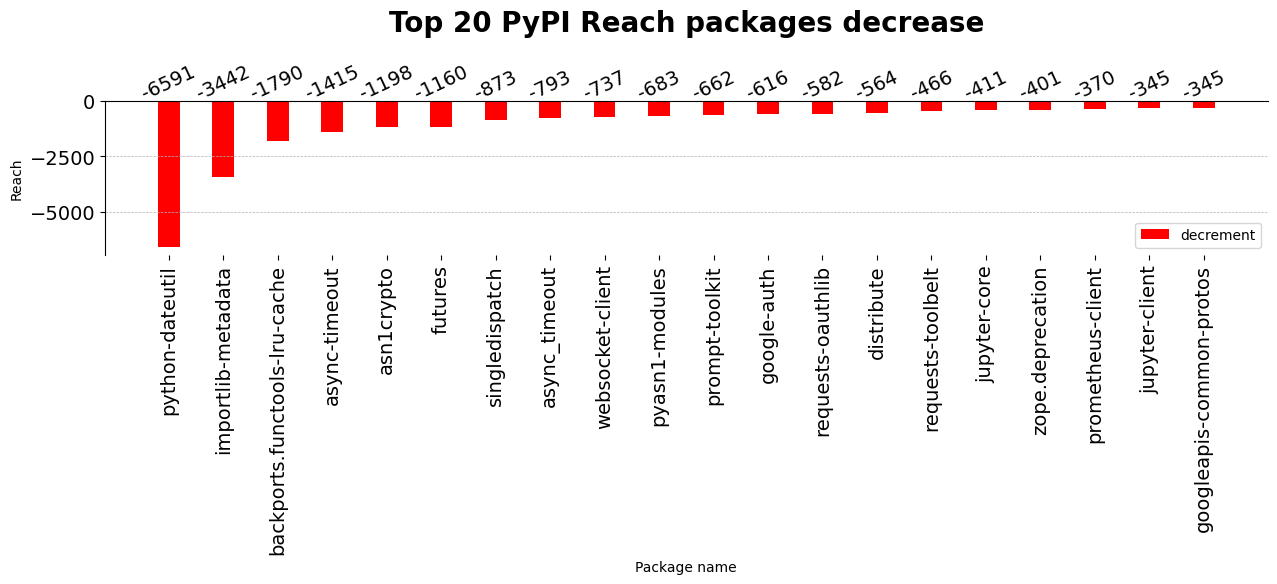

In [ ]:
# Decrease in Reach
reach_df = reach_df.dropna()
decrement = reach_df.tail(20)

# sort by increment
decrement.sort_values(by='increment', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(15, 2))

plt.bar(
    decrement.index,
    decrement['increment'],
    label='decrement',
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 100, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top 20 {REPO_NAME} Reach packages decrease', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


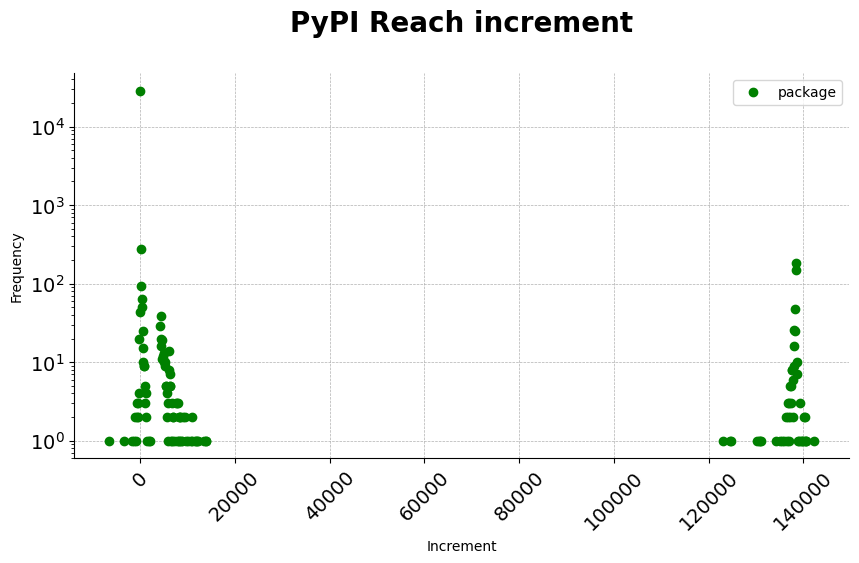

In [ ]:
# Reach variation
# ---------------

reach_increment = list(reach_df['increment'].dropna())

# Plot list of reach increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
reach_increment = [int(x / 100) * 100 for x in reach_increment]
x, y = zip(*Counter(reach_increment).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} Reach increment', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=45)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Reach evolution**

######

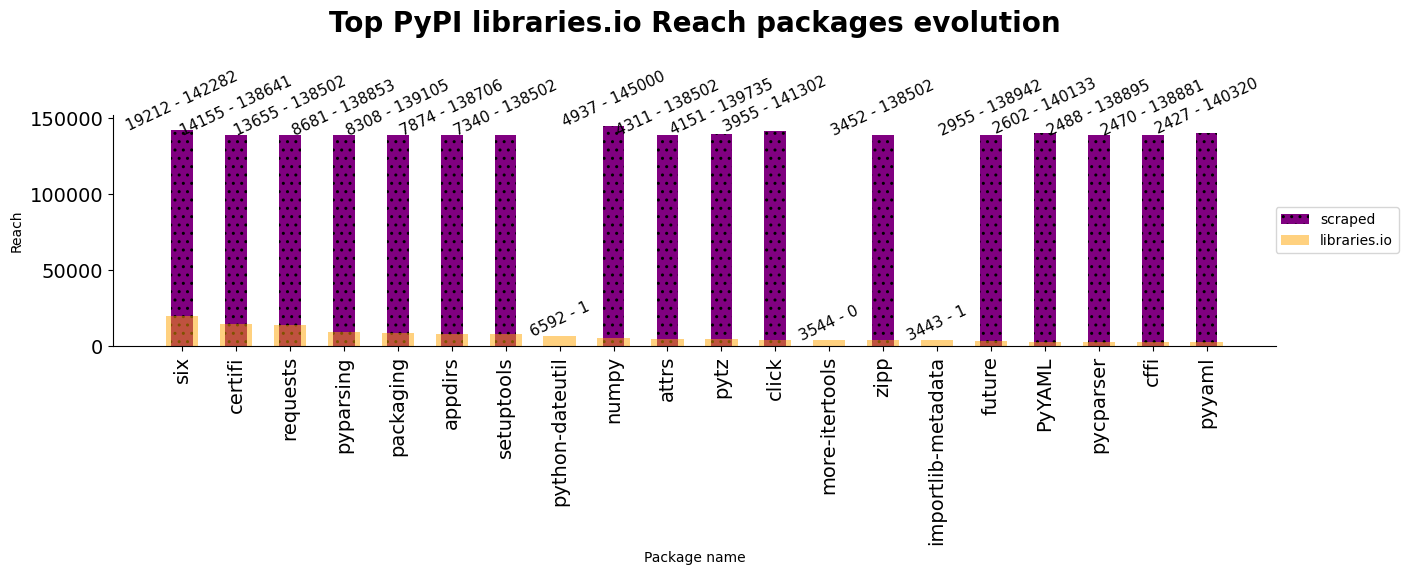

In [ ]:

# Top librariesio reach evolution 
# --------------------------------

# Get the top 10 packages with the highest Reach in the libraries.io model
top_reach_librariesio = dict(librariesio_reach.top(20))

# Get the Reach of the packages in the scraped model
top_reach_scraped = {}
reach_scraped = scraped_reach.results_dict
for package in top_reach_librariesio.keys():
    if package in reach_scraped.keys():
        top_reach_scraped[package] = reach_scraped[package]
    else:
        top_reach_scraped[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} libraries.io Reach packages evolution', fontsize=20, fontweight='bold', pad=60)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(1, 0.4))

plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_reach_evolution.png', bbox_inches='tight')
plt.show()

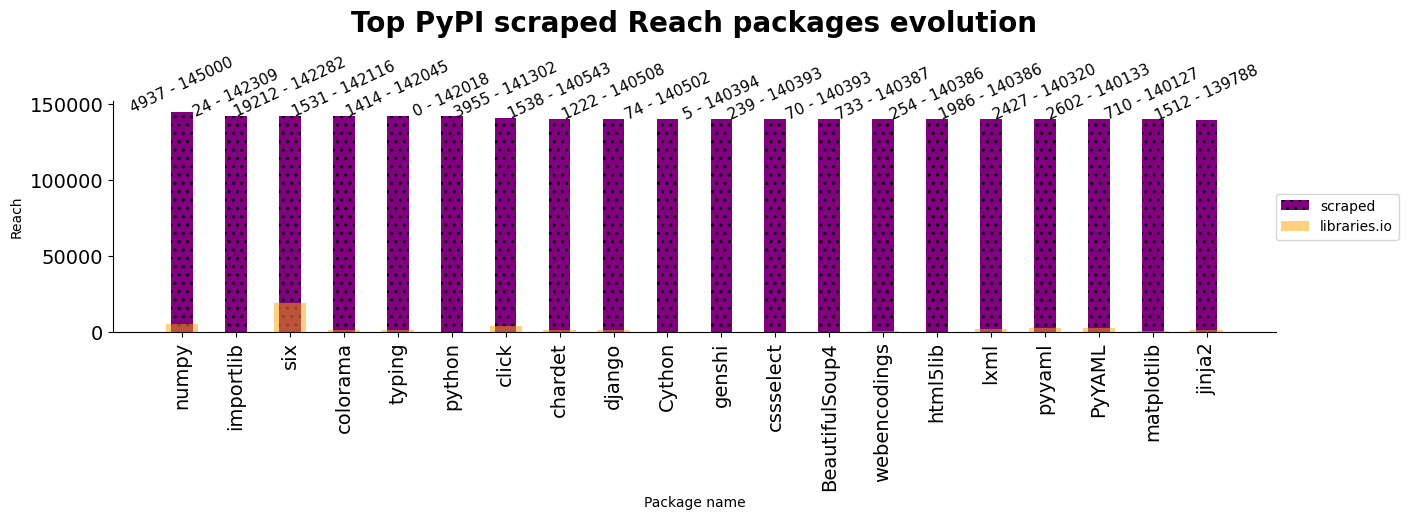

In [ ]:
# Top scraped reach evolution
# ----------------------------

# Get the top 10 packages with the highest Reach in the scraped model
top_reach_scraped = dict(scraped_reach.top(20))

# Get the Reach of the packages in the libraries.io model
top_reach_librariesio = {}
reach_librariesio = librariesio_reach.results_dict
for package in top_reach_scraped.keys():
    if package in reach_librariesio.keys():
        top_reach_librariesio[package] = reach_librariesio[package]
    else:
        top_reach_librariesio[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)
plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped Reach packages evolution', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(1, 0.4))

plt.savefig(f'{OUT_IMG_DIR}/top_scraped_reach_evolution.png', bbox_inches='tight')
plt.show()


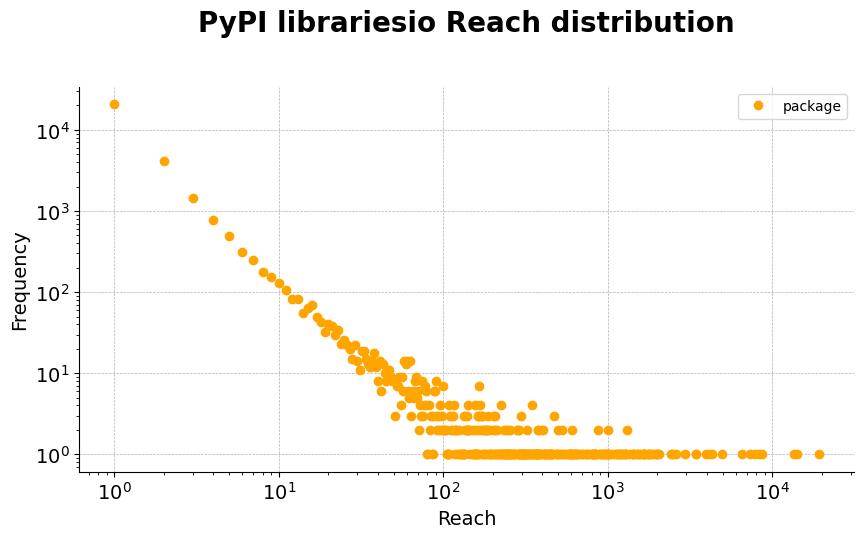

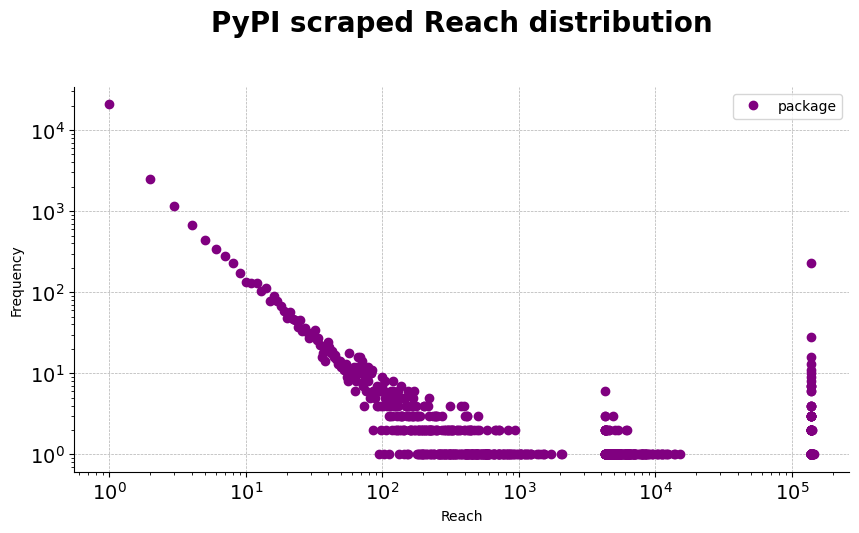

In [ ]:
# Reach distribution for libraries.io
# -----------------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['librariesio'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} librariesio Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_reach_distribution.png', bbox_inches='tight')
plt.show()


# Reach distribution for scraped
# -----------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['scraped'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} scraped Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/scraped_reach_distribution.png', bbox_inches='tight')
plt.show()



#### **4 - Impact**

In [ ]:
from olivia.packagemetrics import Impact

librariesio_impact = librariesio_model.get_metric(Impact)
scraped_impact = scraped_model.get_metric(Impact)

Computing Impact
     Processing node: 49K      
Computing Impact
     Processing node: 213K      


**Top impact**

######

In [ ]:
# Top 10 impact
# -------------

top10_impact_librariesio = librariesio_impact.top(10)
top10_impact_scraped = scraped_impact.top(10)

# Top 10 impact comparison
top10_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_impact_librariesio,
        'scraped': top10_impact_scraped
    }
)

top10_impact_comparison

,librariesio,scraped
0,"(six, 36757)","(numpy, 448177)"
1,"(certifi, 18739)","(six, 424014)"
2,"(requests, 17740)","(python, 422180)"
3,"(pyparsing, 14111)","(importlib, 420861)"
4,"(packaging, 13433)","(typing, 417287)"
5,"(appdirs, 12619)","(colorama, 416663)"
6,"(setuptools, 11803)","(matplotlib, 414520)"
7,"(python-dateutil, 9825)","(chardet, 413067)"
8,"(numpy, 7396)","(Cython, 412181)"
9,"(pytz, 6878)","(click, 411954)"


**Bottom impact**

######

In [ ]:
# Top 10 less impact
# ------------------

top10_less_impact_librariesio = librariesio_impact.bottom(10)
top10_less_impact_scraped = scraped_impact.bottom(10)

# Top 10 less impact comparison
top10_less_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_less_impact_librariesio,
        'scraped': top10_less_impact_scraped
    }
)

top10_less_impact_comparison

,librariesio,scraped
0,"(pytest-testdox, 0)","(LogReporter, 0)"
1,"(pytest-json-report, 0)","(LogoRestClient, 0)"
2,"(pytest-random-order, 0)","(logger-hub, 0)"
3,"(pytest-twisted, 0)","(lockdoor-framework, 0)"
4,"(pytest-markers-presence, 0)","(location-ipfire-db-reader, 0)"
5,"(pytest-only, 0)","(load-m3u8, 0)"
6,"(nutsflow, 0)","(llmapi-cli, 0)"
7,"(mydict, 0)","(lixinAPI, 0)"
8,"(optimuspyspark, 0)","(liveatlas, 0)"
9,"(1pass, 0)","(0x-sra-client, 0)"


**Top impact increase, decrease y variation**

######

In [ ]:
# Dataframe with the increments between the two models
librariesio_impact_df = pd.DataFrame(librariesio_impact.results_dict, index=['librariesio']).T
scraped_impact_df = pd.DataFrame(scraped_impact.results_dict, index=['scraped']).T

impact_df = pd.concat([librariesio_impact_df, scraped_impact_df], axis=1)
impact_df['increment'] = impact_df['scraped'] - impact_df['librariesio']
impact_df.sort_values(by='increment', ascending=False, inplace=True)
impact_df.head(10)

,librariesio,scraped,increment
numpy,7396.0,448177.0,440781.0
importlib,24.0,420861.0,420837.0
colorama,1795.0,416663.0,414868.0
typing,2434.0,417287.0,414853.0
matplotlib,748.0,414520.0,413772.0
Cython,75.0,412181.0,412106.0
chardet,1707.0,413067.0,411360.0
BeautifulSoup4,75.0,411391.0,411316.0
genshi,5.0,411290.0,411285.0
cssselect,260.0,411490.0,411230.0


<Figure size 1500x300 with 0 Axes>

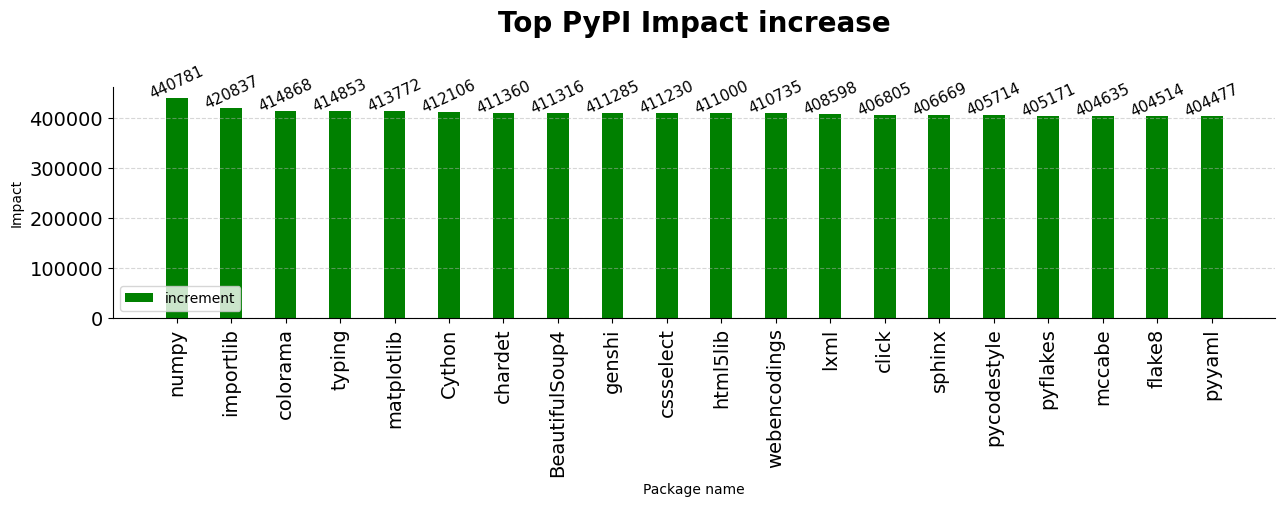

In [ ]:
# Plot increment
plt.figure(figsize=(15, 3))
increment = impact_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 3))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Impact increase', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


**Top impact decrease**

######

In [ ]:
# Decrease in impact
impact_df = impact_df.dropna()
impact_df.tail(10)

,librariesio,scraped,increment
pyasn1-modules,1101.0,0.0,-1101.0
singledispatch,1213.0,87.0,-1126.0
oslo.utils,1242.0,0.0,-1242.0
futures,2277.0,816.0,-1461.0
oslo.i18n,1503.0,0.0,-1503.0
asn1crypto,2503.0,817.0,-1686.0
async-timeout,1828.0,0.0,-1828.0
backports.functools-lru-cache,1944.0,0.0,-1944.0
importlib-metadata,4677.0,0.0,-4677.0
python-dateutil,9825.0,0.0,-9825.0


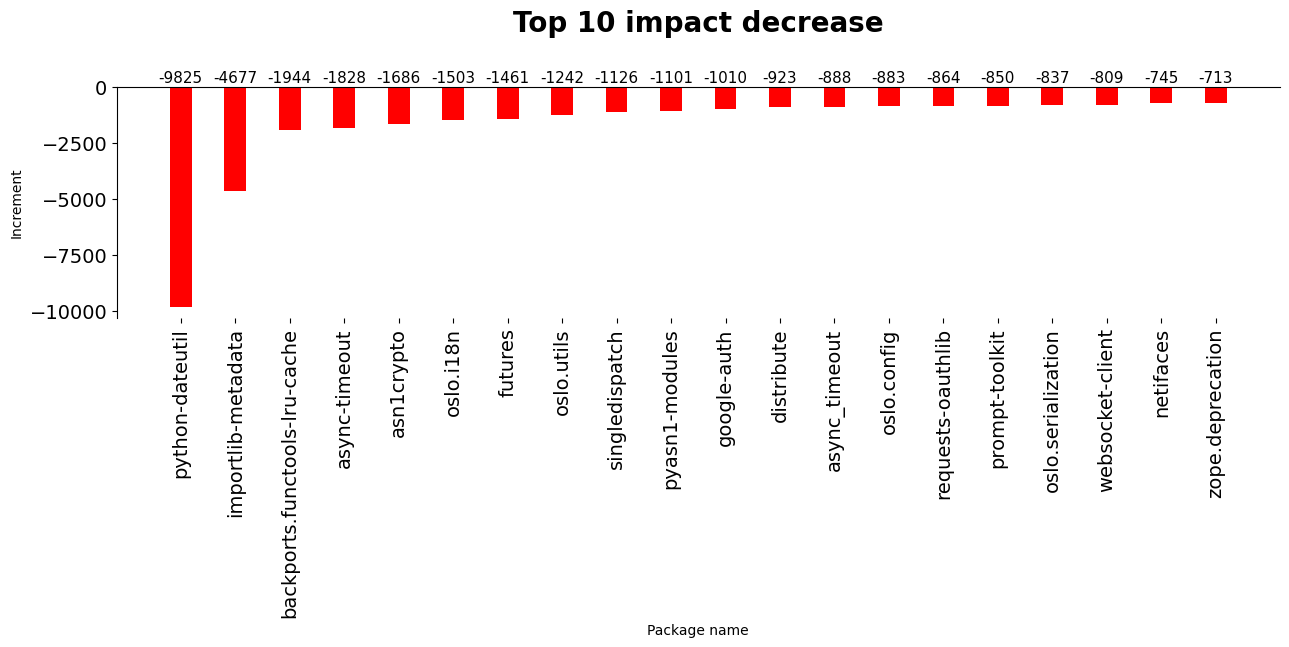

In [ ]:
# Plot decrease
plt.figure(figsize=(15, 3))
decrease = impact_df.tail(20).astype(int)

# sort by increment
decrease.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrease.index,
    decrease['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrease.index, decrease['increment']):
    plt.text(i, 200, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top 10 impact decrease', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/impact_decrease.png', bbox_inches='tight')
plt.show()


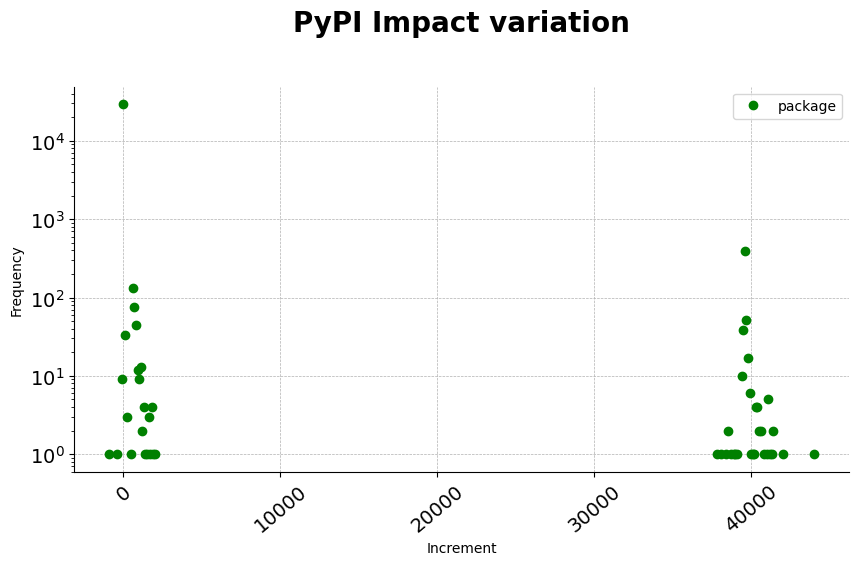

In [ ]:
# Reach variation
# ---------------

impact_increase = list(impact_df['increment'].dropna())
impact_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
impact_increase = [int(x / 1000) * 100 for x in impact_increase]
x, y = zip(*Counter(impact_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact variation', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=40)
plt.gca().tick_params(axis='y', labelsize=14)
plt.ylabel('Frequency')
plt.xlabel('Increment')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Evolution**

######

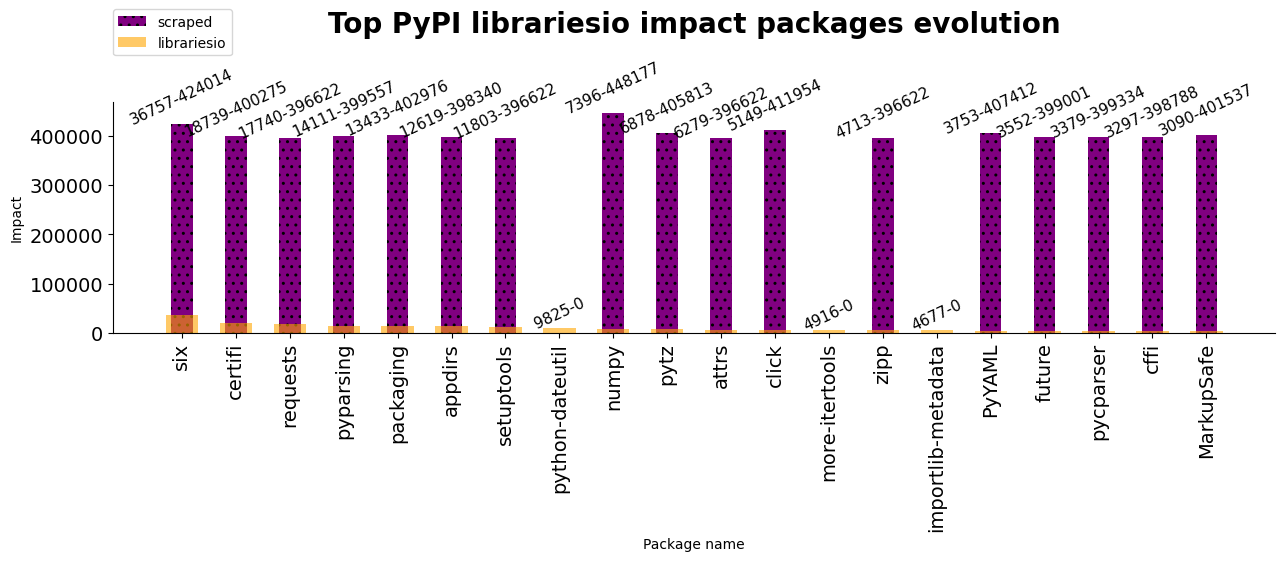

In [ ]:
# Top librariesio impact packages evolution
# -----------------------------------------

top_impact_librariesio = dict(librariesio_impact.top(20))

# Get the impact of the top librariesio packages in the scraped model
top_impact_scraped = {}
for package in top_impact_librariesio.keys():
    try:
        top_impact_scraped[package] = scraped_impact.results_dict[package]
    except KeyError:
        top_impact_scraped[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))



plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

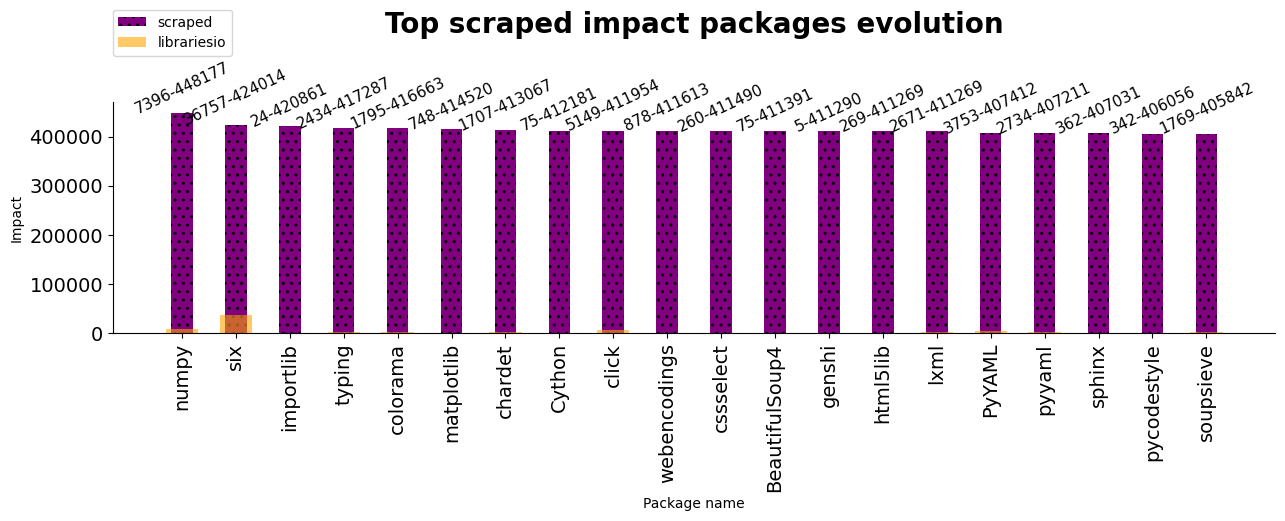

In [ ]:
# Top scraped impact packages evolution
# -------------------------------------

# order impact by librariesio value
impact_df.sort_values(by='scraped', ascending=False, inplace=True)
top_impact_scraped = dict(impact_df.head(20)['scraped'])

# Get the impact of the top scraped packages in the librariesio model
top_impact_librariesio = {}
for package in top_impact_scraped.keys():
    try:
        top_impact_librariesio[package] = librariesio_impact.results_dict[package]
    except KeyError:
        top_impact_librariesio[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top scraped impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_scraped_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

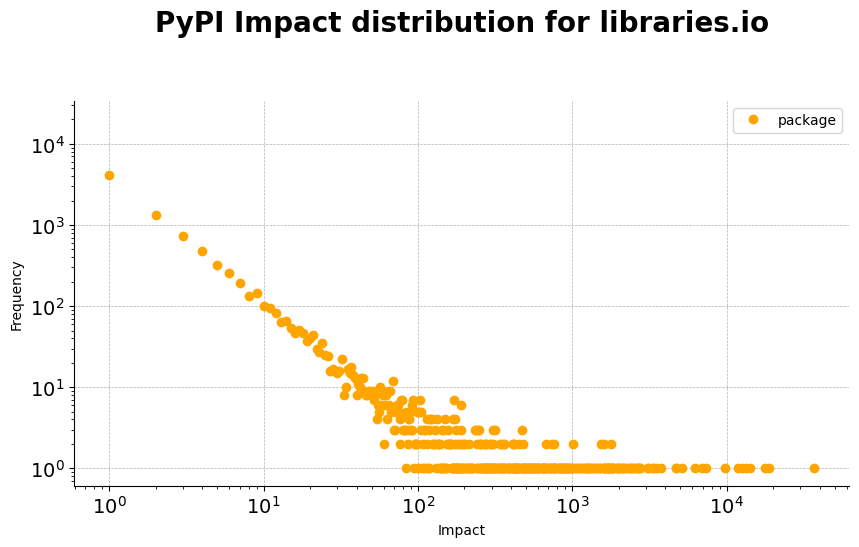

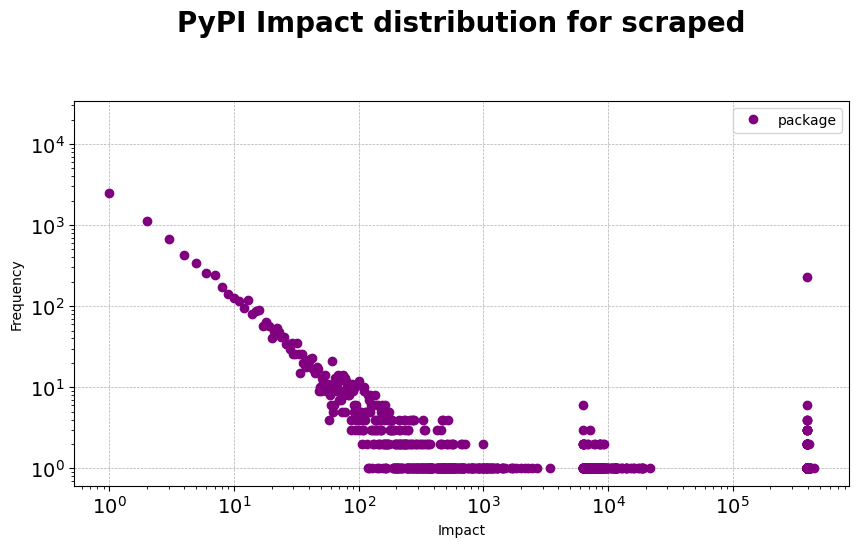

In [ ]:
# Impact distribution for libraries.io
# ------------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['librariesio'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact distribution for libraries.io', fontsize=20, fontweight='bold', pad=50)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')




# save plot
plt.savefig(f'{OUT_IMG_DIR}/librariesio_impact_distribution.png', bbox_inches='tight')
plt.show()

# Impact distribution for scraped
# -------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['scraped'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} Impact distribution for scraped', fontsize=20, fontweight='bold', pad=50)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

#Calcular el valor medio de la distribución

# save plot
plt.savefig(f'{OUT_IMG_DIR}/scraped_impact_distribution.png', bbox_inches='tight')
plt.show()






#### **5 - Surface**

In [ ]:
from olivia.packagemetrics import Surface

librariesio_surface = librariesio_model.get_metric(Surface)
scraped_surface = scraped_model.get_metric(Surface)

Computing Surface
     Processing node: 0K       
Computing Surface
     Processing node: 0K        


**Top surface**

######

In [ ]:
# Top 10 surface comparison
# -------------------------

top10_librariesio_surface = librariesio_surface.top(10)
top10_scraped_surface = scraped_surface.top(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

,librariesio,scraped
0,"(magnum, 145)","(tifascore, 1500)"
1,"(octavia, 144)","(adaseq, 1497)"
2,"(brasil.gov.tiles, 144)","(modelscope, 1496)"
3,"(vitrage, 144)","(geospatial-ml, 1421)"
4,"(cinderlib, 142)","(sdss-marvin, 1403)"
5,"(cinder, 141)","(NLP-Cryptography, 1390)"
6,"(ceilometer-powervm, 141)","(synthcity, 1384)"
7,"(nova, 141)","(marvin, 1383)"
8,"(karbor, 138)","(ai-python, 1381)"
9,"(cloudscript, 137)","(napari-chatgpt, 1378)"


**Bottom surface**

###### 

In [ ]:
# Top 10 less surface
# ----------------

top10_librariesio_surface = librariesio_surface.bottom(10)
top10_scraped_surface = scraped_surface.bottom(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

,librariesio,scraped
0,"(tvdb-api, 1)","(w3lib, 1)"
1,"(stop-words, 1)","(grpclib, 1)"
2,"(cycler, 1)","(hkdf, 1)"
3,"(jpype1, 1)","(peewee, 1)"
4,"(alchimia, 1)","(grpcio, 1)"
5,"(python-pam, 1)","(frozenlist, 1)"
6,"(ipcalc, 1)","(changelogfromtags, 1)"
7,"(boto3-session-cache, 1)","(webob, 1)"
8,"(crosscap, 1)","(webtest, 1)"
9,"(unit_system, 1)","(testit, 1)"


**Top surface increment**

######

In [ ]:
# Dataframe with the increments between the two models
librariesio_surface_df = pd.DataFrame(librariesio_surface.results_dict, index=['librariesio']).T
scraped_surface_df = pd.DataFrame(scraped_surface.results_dict, index=['scraped']).T

surface_df = pd.concat([librariesio_surface_df, scraped_surface_df], axis=1)
surface_df['increment'] = surface_df['scraped'] - surface_df['librariesio']
surface_df.sort_values(by='increment', ascending=False, inplace=True)
surface_df.head(10)


,librariesio,scraped,increment
cityenergyanalyst,8.0,1348.0,1340.0
sdss-marvin,74.0,1403.0,1329.0
wharf,8.0,1334.0,1326.0
pipelinex,2.0,1324.0,1322.0
ballet,11.0,1326.0,1315.0
featuretools,31.0,1320.0,1289.0
autonormalize,32.0,1320.0,1288.0
sagas,21.0,1303.0,1282.0
bugbug,2.0,1281.0,1279.0
darts,2.0,1280.0,1278.0


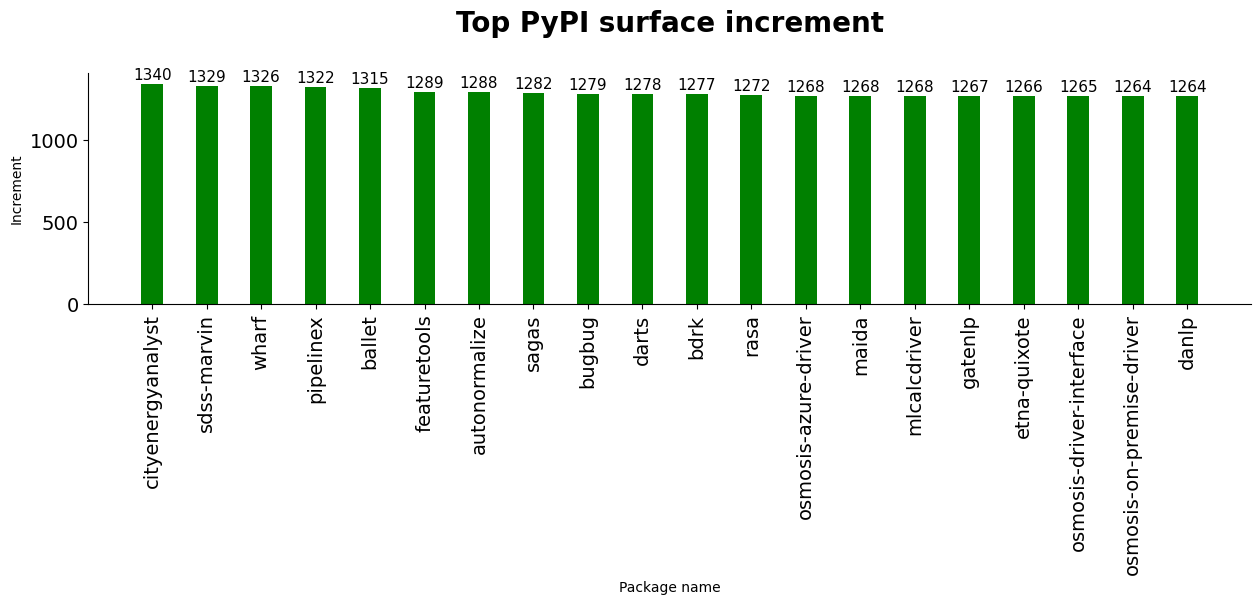

In [ ]:
# Plot surface increment
plt.figure(figsize=(15, 3))

increment = surface_df.head(20).astype(int)

plt.bar(
    increment.index,
    increment['increment'],
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v+30, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface increment', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/top_surface_increment.png', bbox_inches='tight')
plt.show()


**Top surface decrease**

######

In [ ]:
# Decrease in surface
# -------------------

# Remove the rows with NaN values
surface_df = surface_df.dropna()
surface_df.tail(10)

,librariesio,scraped,increment
pywwt,66.0,1.0,-65.0
swifter,66.0,1.0,-65.0
histomicsui,72.0,5.0,-67.0
nova-lxd,72.0,5.0,-67.0
airflow-aws-cost-explorer,75.0,2.0,-73.0
otree,77.0,1.0,-76.0
rucio,81.0,1.0,-80.0
starfish,86.0,1.0,-85.0
kubeflow,88.0,1.0,-87.0
localstack,93.0,1.0,-92.0


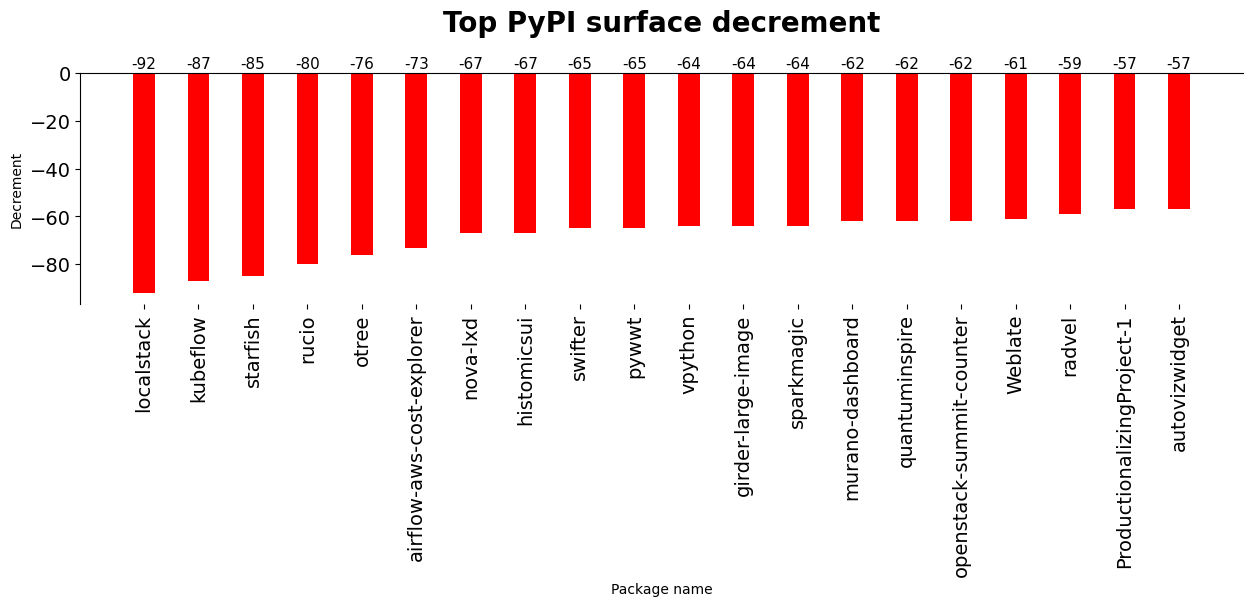

In [ ]:
# Plot surface decrement
plt.figure(figsize=(15, 3))

decrement = surface_df.tail(20).astype(int)

decrement.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrement.index,
    decrement['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 2, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface decrement', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')

plt.ylabel('Decrement')
plt.show()


**Evolution**

######

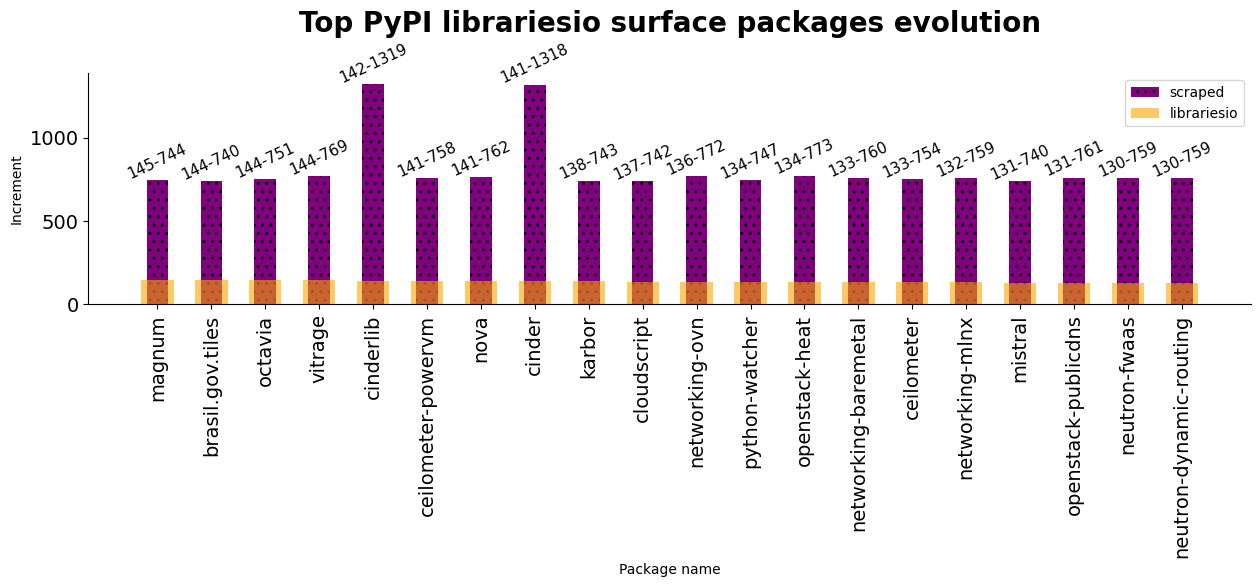

In [ ]:
# Evolution of the top librariesio surface packages
# ------------------------------------------------

# order surface by librariesio value
surface_df.sort_values(by='librariesio', ascending=False, inplace=True)
top_surface_librariesio = dict(surface_df.head(20)['librariesio'])

# Get the surface of the top librariesio packages for scraped model
top_surface_scraped = {}
for package in top_surface_librariesio.keys():
    try:
        top_surface_scraped[package] = scraped_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in scraped model')
        top_surface_scraped[package] = 0

# Plot the evolution of the top librariesio surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],

    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_scraped.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v)}-{v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio surface packages evolution', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend()

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


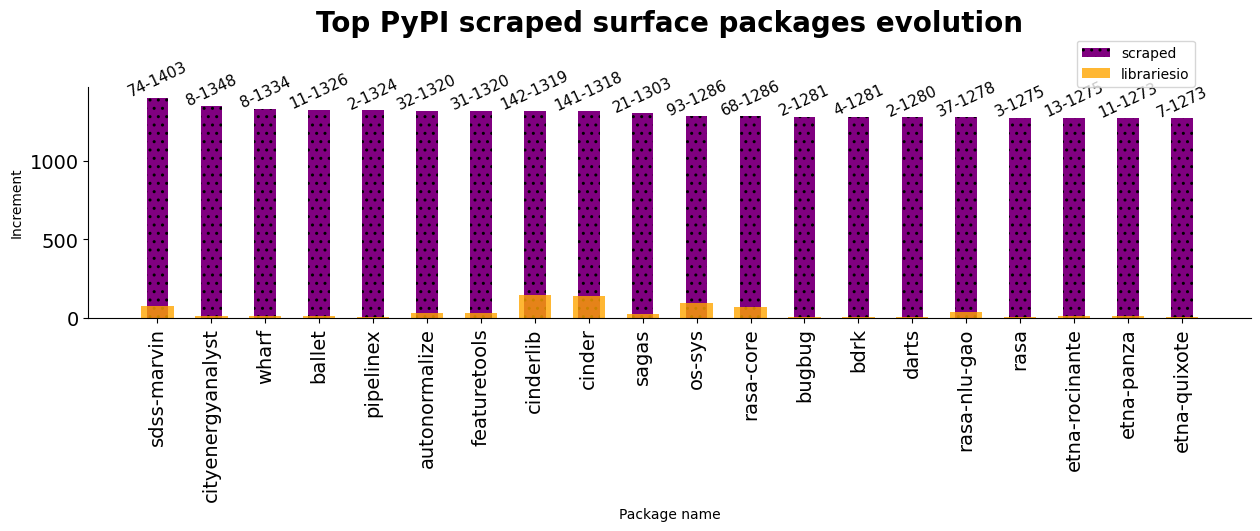

In [ ]:
# Evolution of the top scraped surface packages
# ---------------------------------------------

# order surface by scraped value
surface_df.sort_values(by='scraped', ascending=False, inplace=True)
top_surface_scraped = dict(surface_df.head(20)['scraped'])

# Get the surface of the top scraped packages for librariesio model
top_surface_librariesio = {}
for package in top_surface_scraped.keys():
    try:
        top_surface_librariesio[package] = librariesio_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in librariesio model')
        top_surface_librariesio[package] = 0

# Plot the evolution of the top scraped surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.8,
)

for i, v, v2 in zip([x[0] for x in top_surface_scraped.items()], [x[1] for x in top_surface_scraped.items()], [x[1] for x in top_surface_librariesio.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v2)}-{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped surface packages evolution', fontsize=20, fontweight='bold', pad=40)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend(loc=(0.85,1))

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


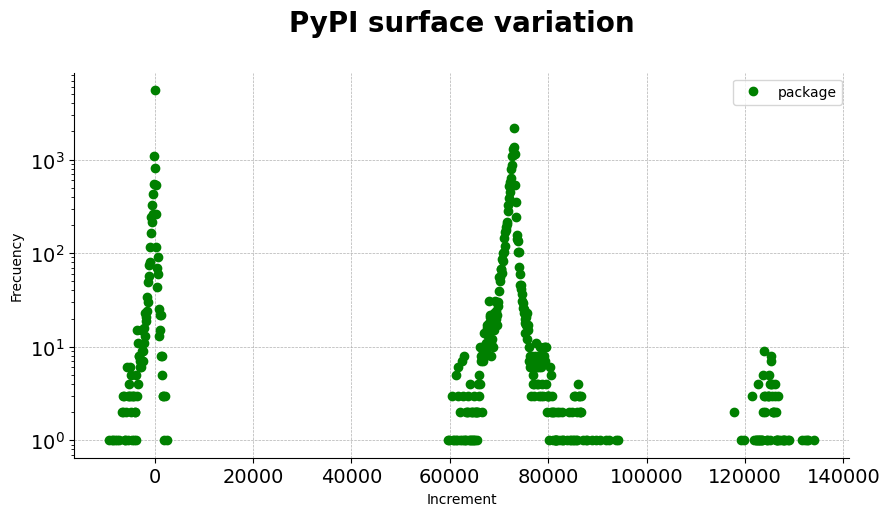

In [ ]:
# Surface variation
# ---------------

surface_increase = list(surface_df['increment'].dropna())
surface_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

surface_increase = [int(x / 1) * 100 for x in surface_increase]
x, y = zip(*Counter(surface_increase).items())
plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} surface variation', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frecuency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/surface_variation.png', bbox_inches='tight')
plt.show()

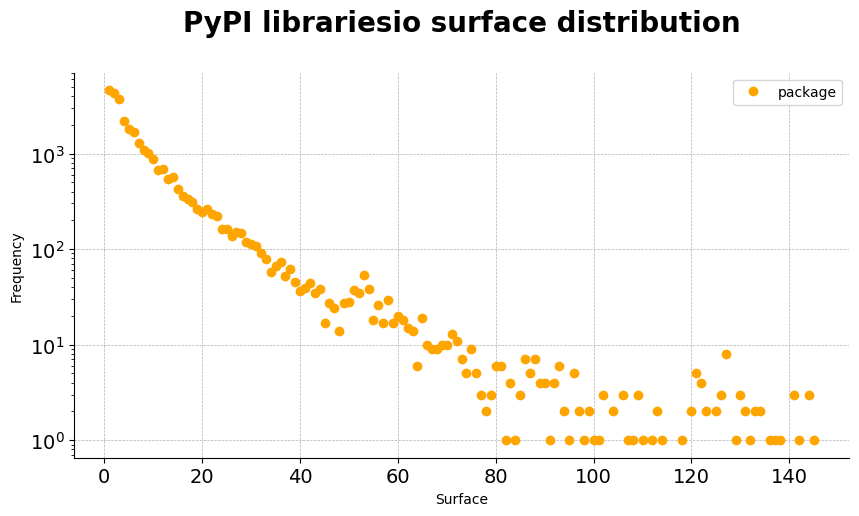

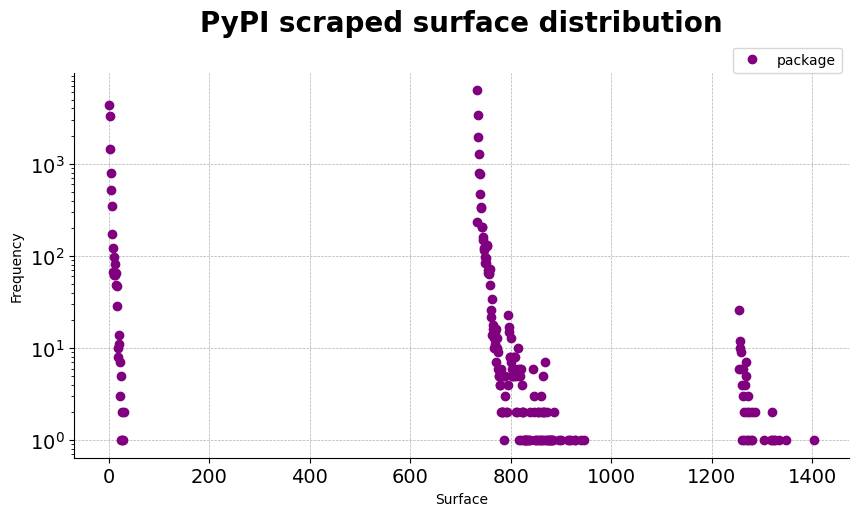

In [ ]:
# Surface distribution for libraries.io
# -------------------------------------

# Plot Surface distribution
import statistics


plt.figure(figsize=(10, 5))
surface = list(surface_df['librariesio'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} librariesio surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_surface_distribution.png', bbox_inches='tight')
plt.show()

# Surface distribution for scraped
# --------------------------------

# Plot Surface distribution
plt.figure(figsize=(10, 5))
surface = list(surface_df['scraped'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} scraped surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend(loc=(0.85,1))
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.xscale('log')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/scraped_surface_distribution.png', bbox_inches='tight')
plt.show()

#### Dependencies

In [ ]:
from olivia.packagemetrics import DependenciesCount

librariesio_dependencies = librariesio_model.get_metric(DependenciesCount)
scraped_dependencies = scraped_model.get_metric(DependenciesCount)

Computing Dependencies Count
Computing Dependencies Count


**Top dependencies**

###### 

In [ ]:
# Top 10 dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.top(10)
top10_scraped_dependencies_count = scraped_dependencies.top(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

,librariesio,scraped
0,"(cloudscript, 120)","(ai-python, 358)"
1,"(c7n-azure, 105)","(NLP-Cryptography, 352)"
2,"(TEStribute, 102)","(ivystar, 265)"
3,"(nucypher, 96)","(animal-classification, 230)"
4,"(azure-cli, 72)","(bitfount, 218)"
5,"(cateye, 72)","(luisito1996, 211)"
6,"(mycloud-cli, 71)","(luisito19963, 210)"
7,"(cloudview, 69)","(luis1996, 208)"
8,"(ML-Navigator, 68)","(omdenalore, 206)"
9,"(nova, 68)","(trialtracker, 200)"


**Bottom dependencies**

###### 

In [ ]:
# Top 10 less dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.bottom(10)
top10_scraped_dependencies_count = librariesio_dependencies.bottom(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

,librariesio,scraped
0,"(www-authenticate, 0)","(www-authenticate, 0)"
1,"(tensorflow, 0)","(tensorflow, 0)"
2,"(biopy-isatab, 0)","(biopy-isatab, 0)"
3,"(ftw.slider, 0)","(ftw.slider, 0)"
4,"(z3c.schema, 0)","(z3c.schema, 0)"
5,"(ftw.zipexport, 0)","(ftw.zipexport, 0)"
6,"(ftw.iframefix, 0)","(ftw.iframefix, 0)"
7,"(plone.app.blob, 0)","(plone.app.blob, 0)"
8,"(django-ace-overlay, 0)","(django-ace-overlay, 0)"
9,"(errand-boy, 0)","(errand-boy, 0)"


**Top dependencies increment**

###### 

In [ ]:
# Dataframe with the differences between the two models
librariesio_dependencies_count_df = pd.DataFrame(librariesio_dependencies.results_dict, index=['librariesio']).T
scraped_dependencies_count_df = pd.DataFrame(scraped_dependencies.results_dict, index=['scraped']).T

dependencies_count_df = pd.concat([librariesio_dependencies_count_df, scraped_dependencies_count_df], axis=1)
dependencies_count_df['increment'] = dependencies_count_df['scraped'] - dependencies_count_df['librariesio']
dependencies_count_df.sort_values(by='increment', ascending=False, inplace=True)
dependencies_count_df.head(10)

,librariesio,scraped,increment
apache-airflow,41.0,185.0,144.0
sentry,23.0,115.0,92.0
raiden,0.0,88.0,88.0
crossbar,10.0,89.0,79.0
pyswarms,2.0,78.0,76.0
rasa,1.0,68.0,67.0
XTCryptoSignals,20.0,84.0,64.0
seleniumbase,17.0,79.0,62.0
c7n-mailer,11.0,69.0,58.0
panel,5.0,63.0,58.0


**Top dependencies decrement**

###### 

In [ ]:
# Decrease in dependencies count
# -------------------

# Remove the rows with NaN values
dependencies_count_df = dependencies_count_df.dropna()
dependencies_count_df.tail(10)

,librariesio,scraped,increment
koku-nise,46.0,8.0,-38.0
the-whole-caboodle,43.0,5.0,-38.0
zbuilder,60.0,21.0,-39.0
horizon,61.0,21.0,-40.0
edx-enterprise-data,60.0,17.0,-43.0
c7n-azure,105.0,47.0,-58.0
otree,58.0,0.0,-58.0
rucio,60.0,0.0,-60.0
cateye,72.0,2.0,-70.0
cloudscript,120.0,36.0,-84.0


**Evolution**

###### 

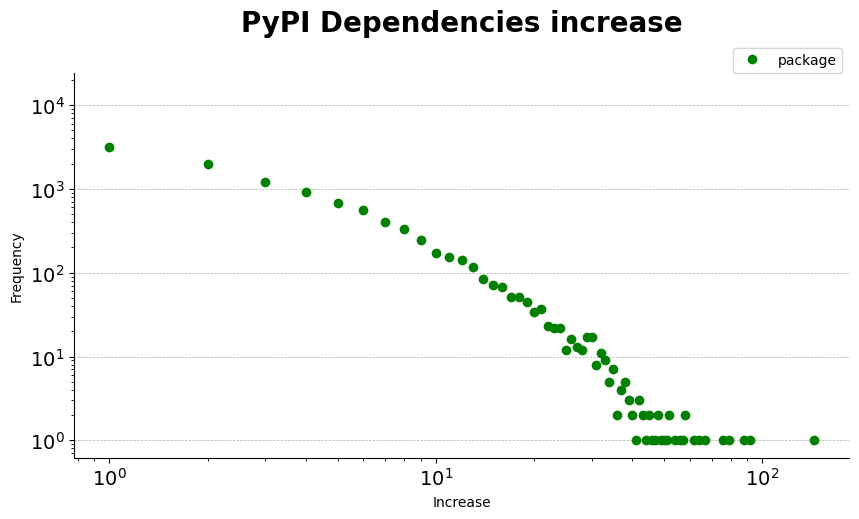

In [ ]:
# Dependencies variation
# --------------------------------

dependencies_increase = list(dependencies_count_df['increment'].dropna())
dependencies_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

x, y = zip(*Counter(dependencies_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependencies increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependencies_increase.png', bbox_inches='tight')
plt.show()






#### Dependents

In [ ]:
from olivia.packagemetrics import DependentsCount

librariesio_dependents = librariesio_model.get_metric(DependentsCount)
scraped_dependents = scraped_model.get_metric(DependentsCount)

Computing Dependents Count
Computing Dependents Count


In [ ]:
# Top 10 dependents count
# ----------------

top10_librariesio_dependents_count = librariesio_dependents.top(10)
top10_scraped_dependents_count = scraped_dependents.top(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)
top10_dependents_count_df

,librariesio,scraped
0,"(requests, 10156)","(numpy, 39295)"
1,"(six, 4451)","(requests, 37816)"
2,"(numpy, 3773)","(pandas, 25584)"
3,"(click, 2403)","(pytest, 24354)"
4,"(setuptools, 1921)","(matplotlib, 16979)"
5,"(python-dateutil, 1735)","(scipy, 15892)"
6,"(pyyaml, 1656)","(python, 15668)"
7,"(PyYAML, 1390)","(odoo, 13794)"
8,"(lxml, 1215)","(click, 12657)"
9,"(pandas, 1129)","(tqdm, 10382)"


In [ ]:
# Top 10 less dependents count
# ----------------------------

top10_librariesio_dependents_count = librariesio_dependents.bottom(10)
top10_scraped_dependents_count = scraped_dependents.bottom(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)

top10_dependents_count_df

,librariesio,scraped
0,"(ddlworker, 0)","(openimis-be-calculation, 0)"
1,"(enturclient, 0)","(openimis-be-calcrule-capitation-payment, 0)"
2,"(graph-nets, 0)","(openImagePreprocessing, 0)"
3,"(bulb-core, 0)","(openhub-django, 0)"
4,"(edp-cli, 0)","(openhab-pythonrule-engine, 0)"
5,"(mozdef-util, 0)","(opengov, 0)"
6,"(gofer-grader, 0)","(OpenGeode-IO, 0)"
7,"(django-exo-mentions, 0)","(opengame, 0)"
8,"(sanic-boom, 0)","(openflexure-stage, 0)"
9,"(django-pyodbc-azure-2019, 0)","(matos-aws-provider, 0)"


In [ ]:
# Dataframe with the differences between the two models
librariesio_dependents_count_df = pd.DataFrame(librariesio_dependents.results_dict, index=['librariesio']).T
scraped_dependents_count_df = pd.DataFrame(scraped_dependents.results_dict, index=['scraped']).T

dependents_count_df = pd.concat([librariesio_dependents_count_df, scraped_dependents_count_df], axis=1)
dependents_count_df['difference'] = dependents_count_df['scraped'] - dependents_count_df['librariesio']
dependents_count_df.sort_values(by='difference', ascending=False, inplace=True)
dependents_count_df.head(10)

,librariesio,scraped,difference
numpy,3773.0,39295.0,35522.0
requests,10156.0,37816.0,27660.0
pandas,1129.0,25584.0,24455.0
pytest,900.0,24354.0,23454.0
matplotlib,658.0,16979.0,16321.0
scipy,738.0,15892.0,15154.0
click,2403.0,12657.0,10254.0
tqdm,795.0,10382.0,9587.0
sphinx,219.0,8664.0,8445.0
flake8,165.0,8004.0,7839.0


In [ ]:
# Decrease in dependents count
# -------------------

# Remove the rows with NaN values
dependents_count_df = dependents_count_df.dropna()
dependents_count_df.tail(10)

,librariesio,scraped,difference
public,158.0,11.0,-147.0
aws-cdk.core,153.0,0.0,-153.0
oslo.utils,153.0,0.0,-153.0
Adafruit-Blinka,154.0,0.0,-154.0
python-dotenv,176.0,0.0,-176.0
requests-toolbelt,178.0,0.0,-178.0
websocket-client,217.0,0.0,-217.0
scikit-learn,217.0,0.0,-217.0
google-api-python-client,220.0,0.0,-220.0
python-dateutil,1735.0,0.0,-1735.0


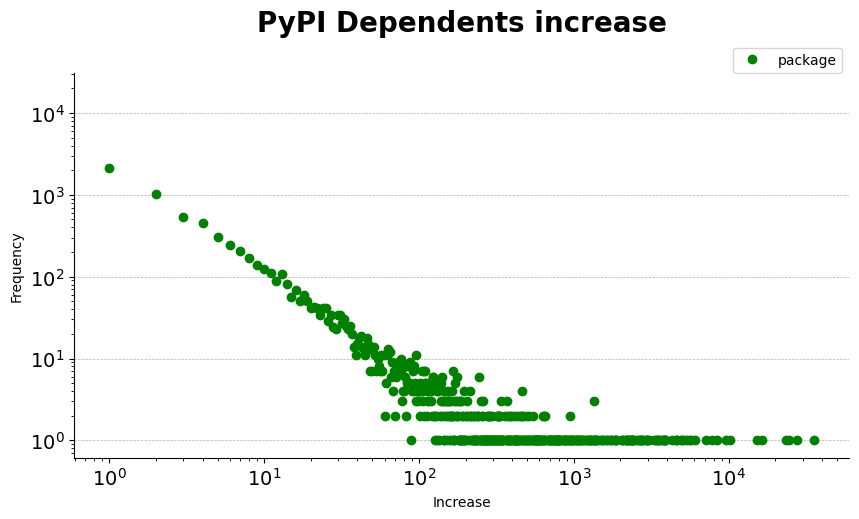

In [ ]:
# Dependents variation
# --------------------------------

dependents_increase = list(dependents_count_df['difference'].dropna())
dependents_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

x, y = zip(*Counter(dependents_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependents increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependents_increase.png', bbox_inches='tight')
plt.show()
